In [5]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot

import pandas as pd
import sklearn
from sklearn.datasets import load_diabetes
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

In [6]:
import sys
import logging
import datetime

nblog = open("./logs/catboost_pdp_shap_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Autosaving every 5 seconds


In [7]:
%%time
df_localness = pd.read_csv('./data/food_localness_final_oct_new.csv')
print('unique orders:',df_localness.shape[0])
print('unique accounts:',df_localness.account_id.unique().shape[0])
df_localness.head(2)

unique orders: 2782961
unique accounts: 556124
CPU times: user 20.1 s, sys: 3.91 s, total: 24 s
Wall time: 24 s


account_id    order_id  order_date           order_time  vendor_id       vendor_name main_cuisine vertical  delivery_fee_amount_lc  service_fee_amount_lc  basket_amount_lc is_incentive_applied  incentive_amount_lc       pickup_id  customer_lon  customer_lat  vendor_lon  vendor_lat  order_time_hour  delivery_duration  total_duration     node_id  nearest_dist1  poi1 n_vertical  n_vendor_id n_main_cuisine                                        n_vendor_name  n_vendor_lon  n_vendor_lat  vendor_index  pandana_distance_realdist  pandana_localness   speed     customer_loc_id isweekend  price_per_item  entropy_0.5km  restaurant_count_0.5km  entropy_1km  poi_count_1km  entropy_2km  poi_count_2km  entropy_3km  poi_count_3km  entropy_4km  poi_count_4km  entropy_5km  poi_count_5km  restaurant_count_0.5_1km  restaurant_count_1_2km  restaurant_count_2_3km  restaurant_count_3_4km  restaurant_count_4_5km  estimated_rent  compensation  discounted delivery  free delivery     gem  item discount  \
0  1237695     1304769890  2023-10-10  2023-10-10 00:54:08  701885     Subz, AlBarsha 3  american     food    7.50000                 1.92000                64.00000           True                30.00000             249052903.00000 55.14407      25.06988      55.19383    25.08783     0                21                 50              2669233716 0.68807         1778  food       660366       american       Cheat Day - Burgers & Salads, Jumeirah Lakes Towers 55.14022      25.06550       1778         7.29895                    0.09427            8.75754  55.14406625.069883  No       0.00000         0.70242        169.00000               0.73641      322.00000      0.74026      782.00000      0.73911      853.00000      0.73745      933.00000      0.73241      1138.00000     153.00000                 460.00000               71.00000                80.00000                205.00000               87.94369        0.00000       0.00000              0.00000        0.00000 0.00000          
1  1027548     1304769334  2023-10-10  2023-10-10 00:53:16  701885     Subz, AlBarsha 3  american     food    7.50000                 1.92000                64.00000           True                30.00000             249052903.00000 55.14435      25.06983      55.19383    25.08783     0                16                 46              2669233716 0.68807         1778  food       660366       american       Cheat Day - Burgers & Salads, Jumeirah Lakes Towers 55.14022      25.06550       1778         7.29895                    0.09427            9.51906  55.1443525.06983    No       0.00000         0.65899        121.00000               0.73415      318.00000      0.74026      782.00000      0.73911      853.00000      0.73800      933.00000      0.73241      1138.00000     197.00000                 464.00000               71.00000                80.00000                205.00000               88.00245        0.00000       0.00000              0.00000        0.00000 0.00000          

   menu discount  voucher wallet incentives_type  incentive_delivery  incentive_menu_discount  incentive_voucher_wallet  rating     n_rating  consistency  total_orders  
0 30.00000       0.00000          menu discount   False               True                     False                     5.None  2.Very good 0.87874       11            
1 30.00000       0.00000          menu discount   False               True                     False                     5.None  2.Very good 0.88989       23

In [8]:
# df_localness.incentive_voucher_wallet.value_counts()

In [9]:
# 26 features 
df_features = df_localness[['customer_lon','customer_lat',
                            'basket_amount_lc','price_per_item','order_time_hour','total_duration',
                            'estimated_rent', 'entropy_0.5km','entropy_2km','entropy_5km', # these three have VIF>3 so exlcuded: 'entropy_1km', 'entropy_3km','entropy_4km',
                            'incentive_amount_lc','incentive_delivery','incentive_menu_discount', 
                            'incentive_voucher_wallet', 'main_cuisine',
                             'isweekend', 'consistency', 'total_orders', 'rating','n_rating',
                            'restaurant_count_0.5km', 'restaurant_count_0.5_1km','restaurant_count_1_2km',
                            'restaurant_count_2_3km','restaurant_count_3_4km','restaurant_count_4_5km']]

categorical_list = ['isweekend','main_cuisine','incentive_delivery','incentive_menu_discount',
                    'incentive_voucher_wallet','rating','n_rating']

In [23]:
%%time
# check VIF
df_cor = df_features.corr()
pd.DataFrame(np.linalg.inv(df_features.corr().values), index = df_cor.index, columns=df_cor.columns)

CPU times: user 5.13 s, sys: 1.29 s, total: 6.42 s
Wall time: 6.64 s


customer_lon  customer_lat  basket_amount_lc  price_per_item  order_time_hour  total_duration  estimated_rent  entropy_0.5km  entropy_2km  entropy_5km  incentive_amount_lc  incentive_delivery  incentive_menu_discount  incentive_voucher_wallet  consistency  total_orders  restaurant_count_0.5km  restaurant_count_0.5_1km  restaurant_count_1_2km  restaurant_count_2_3km  restaurant_count_3_4km  restaurant_count_4_5km
customer_lon             3.75815       -2.48318      -0.02392          -0.01526        -0.04638         0.11236         0.67940         -0.07977       -0.18513     0.17874      -0.00887             -0.03992            0.04985                  0.00439                   -0.07546     -0.05376      0.32372                 0.34151                   0.40384                 0.37991                 0.64795                 0.76052                
customer_lat             -2.48318      2.82796       0.03772           0.05488         0.05856          -0.15284        -0.03338        0.01789        0.00387      -0.10291     0.03181              0.02579             0.02720                  0.01007                   0.06616      0.06601       -0.07540                -0.25156                  -0.38999                -0.45049                -0.47959                -0.59576               
basket_amount_lc         -0.02392      0.03772       1.15317           -0.17038        -0.04813         -0.23244        -0.06330        0.06340        0.00078      -0.02740     -0.29318             0.09477             0.15726                  0.01268                   -0.02184     0.03631       0.00042                 0.00762                   0.00252                 0.01235                 0.01340                 0.00225                
price_per_item           -0.01526      0.05488       -0.17038          1.09562         -0.01962         -0.03373        -0.05563        -0.01531       -0.01298     -0.01159     -0.14233             0.01261             -0.05924                 -0.01266                  -0.08349     -0.03885      0.00514                 -0.00037                  -0.01032                -0.00649                -0.00068                -0.01487               
order_time_hour          -0.04638      0.05856       -0.04813          -0.01962        1.01699          -0.06697        0.04710         0.03168        -0.00827     -0.02979     0.02022              0.00027             -0.03316                 -0.01446                  -0.00543     0.03345       -0.00269                -0.00691                  0.00851                 0.00534                 0.01411                 0.00750                
total_duration           0.11236       -0.15284      -0.23244          -0.03373        -0.06697         1.10645         -0.10001        -0.04321       0.06086      0.11036      -0.04098             -0.05736            -0.04803                 -0.00700                  -0.00006     0.02166       0.02974                 0.00138                   -0.00262                -0.01296                -0.00923                -0.00438               
estimated_rent           0.67940       -0.03338      -0.06330          -0.05563        0.04710          -0.10001        1.62457         -0.18857       0.20887      -0.16767     0.00090              0.01089             0.02597                  0.01485                   -0.00487     -0.01700      0.15453                 -0.06073                  -0.40250                -0.16603                0.09087                 -0.08159               
entropy_0.5km            -0.07977      0.01789       0.06340           -0.01531        0.03168          -0.04321        -0.18857        2.62318        -0.73970     0.27271      -0.03250             0.00265             -0.03034                 -0.00585                  0.01027      0.04469       -1.28417                -0.35806                  -0.01808                -0.15289                -0.28716                -0.08833               
entropy_2km              -0.18513      0.00387  

# Feature engineering

In [11]:
%%time

X = df_features
y = df_localness.pandana_localness

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# X_train.dtypes

import catboost as cb

train_dataset = cb.Pool(X_train, y_train, cat_features=categorical_list)
test_dataset = cb.Pool(X_test, y_test, cat_features=categorical_list)

print(train_dataset.shape[0])
print(test_dataset.shape[0])

1948072
834889
CPU times: user 15.6 s, sys: 378 ms, total: 16 s
Wall time: 14.4 s


# Hyperparameter tuning using optuna

In [ ]:
%%time
# %pip install optuna
## this step took 10 hours to finish

import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error

def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1200, step=100),
        'max_depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        'loss_function': 'RMSE','eval_metric': 'RMSE'
    }

    # Initialize CatBoostRegressor with the suggested hyperparameters
    model = cb.CatBoostRegressor(cat_features=categorical_list, **params, verbose=0)
    

    # Perform cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    rmse_scorer = make_scorer(mean_squared_error, squared=False)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=rmse_scorer)

    return scores.mean()

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-09-12 12:32:23,909] A new study created in memory with name: no-name-3910936f-1afe-4ccd-bdb6-1611cdbf79c5
[I 2024-09-12 12:36:55,376] Trial 0 finished with value: 0.24121474654697023 and parameters: {'iterations': 1000, 'depth': 5, 'learning_rate': 0.24414634353294834, 'colsample_bylevel': 0.06532691392496023, 'subsample': 0.839817417830171, 'min_data_in_leaf': 49}. Best is trial 0 with value: 0.24121474654697023.
[I 2024-09-12 12:38:49,096] Trial 1 finished with value: 0.2449636566467564 and parameters: {'iterations': 200, 'depth': 9, 'learning_rate': 0.18573620225148113, 'colsample_bylevel': 0.07466440741930125, 'subsample': 0.5862049665528288, 'min_data_in_leaf': 60}. Best is trial 0 with value: 0.24121474654697023.
[I 2024-09-12 12:41:24,253] Trial 2 finished with value: 0.24808321786036477 and parameters: {'iterations': 200, 'depth': 11, 'learning_rate': 0.05162600043148552, 'colsample_bylevel': 0.0969535915692106, 'subsample': 0.3916391907662244, 'min_data_in_leaf': 35}. 

In [26]:
# Output the best hyperparameters
print('Best trial:', study.best_trial.params)
print('Best RMSE:', study.best_trial.value)

Best trial: {'iterations': 1100, 'depth': 12, 'learning_rate': 0.2050902372072541, 'colsample_bylevel': 0.09573953357177008, 'subsample': 0.6055252063094192, 'min_data_in_leaf': 94}
Best RMSE: 0.1951013833116396


# Training

In [27]:
%%time
# ~takes 9min
print(datetime.datetime.now(),'*************** Start running CatBoostRegressor ***************')

# best_params = study.best_trial.params
best_params = {'iterations': 1100, 'depth': 12, 'learning_rate': 0.2050902372072541, 'colsample_bylevel': 0.09573953357177008, 'subsample': 0.6055252063094192, 'min_data_in_leaf': 94}

regressor = cb.CatBoostRegressor(
    **best_params, 
    custom_metric= ['R2', 'RMSE'], early_stopping_rounds=50)
regressor.fit(train_dataset, eval_set = test_dataset)
output_path = './output/current_catboost_' + str(datetime.datetime.now())
regressor.save_model(output_path)

print(datetime.datetime.now(),'*************** Done running CatBoostRegressor ***************')

2024-09-12 21:12:22.033918 *************** Start running CatBoostRegressor ***************
0:	learn: 0.3093815	test: 0.3096147	best: 0.3096147 (0)	total: 479ms	remaining: 8m 46s
1:	learn: 0.3093815	test: 0.3096146	best: 0.3096146 (1)	total: 507ms	remaining: 4m 38s
2:	learn: 0.3039019	test: 0.3041342	best: 0.3041342 (2)	total: 598ms	remaining: 3m 38s
3:	learn: 0.2947207	test: 0.2949231	best: 0.2949231 (3)	total: 874ms	remaining: 3m 59s
4:	learn: 0.2910668	test: 0.2912431	best: 0.2912431 (4)	total: 928ms	remaining: 3m 23s
5:	learn: 0.2910668	test: 0.2912431	best: 0.2912431 (5)	total: 952ms	remaining: 2m 53s
6:	learn: 0.2910668	test: 0.2912431	best: 0.2912431 (6)	total: 975ms	remaining: 2m 32s
7:	learn: 0.2871119	test: 0.2873071	best: 0.2873071 (7)	total: 1.19s	remaining: 2m 42s
8:	learn: 0.2843284	test: 0.2845385	best: 0.2845385 (8)	total: 1.37s	remaining: 2m 46s
9:	learn: 0.2807833	test: 0.2809316	best: 0.2809316 (9)	total: 1.54s	remaining: 2m 47s
10:	learn: 0.2760517	test: 0.2761397	be

# Or load the trained CatBoost model

In [29]:
regressor = cb.CatBoostRegressor()
regressor.load_model('./output/current_catboost_2024-09-12 21:15:44.302560')
# print(regressor.get_all_params())

# Model evaluation

In [30]:
# X_test.head(20)
# X_test.isnull().values.any()

In [30]:
%%time
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(datetime.datetime.now(),'Best Model RMSE: %.3f' % rmse)

r2 = r2_score(y_test, y_pred)
print(datetime.datetime.now(),'Best Model R-squared: %.3f' % r2)
# RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred) )
# Best Model RMSE: 0.193
# Best Model R-squared: 0.631

2024-09-12 21:29:27.495997 Best Model RMSE: 0.193
2024-09-12 21:29:27.502196 Best Model R-squared: 0.631
CPU times: user 14.6 s, sys: 201 ms, total: 14.8 s
Wall time: 4.4 s


# Feature importance
## 1. Impurity importance

In [ ]:
# %%time

# plt.rcParams.update({'font.size': 16})
# fig, ax = plt.subplots(1,1,figsize=(6,9))
# df_feature_importance = pd.DataFrame({'feature_importance': regressor.get_feature_importance(train_dataset), 
#               'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
#                                                        ascending=False)

# df_feature_importance.sort_values(by=['feature_importance'], ascending=True).plot.barh(
#     x='feature_names', y='feature_importance',align='center', color='turquoise',ax=ax)

# # plt.xlabel("CatBoost Feature Importance")
# plt.xlabel('Impurity Importance')
# ax.get_legend().remove()
# ax.set(ylabel=None)
# plt.savefig('./output/feature_importance_impurity.pdf',bbox_inches="tight")

# print(datetime.datetime.now(),'*************** Done running feature importance ***************')

## 2. Permutation importance

In [ ]:
# %%time
# from sklearn.inspection import permutation_importance

# print(datetime.datetime.now(),'*************** Start running permutation_importance ***************')
# plt.rcParams.update({'font.size': 16})
# fig, ax = plt.subplots(1,1,figsize=(6,9))
# perm_importance = permutation_importance(regressor, X_train, y_train, n_repeats=10, random_state=1066, n_jobs=4)
# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center',color='turquoise')
# plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
# plt.xlabel('Permutation Importance')
# plt.savefig('./output/feature_importance_permutation.pdf', bbox_inches='tight')
# print(datetime.datetime.now(),'*************** Done running permutation_importance ***************')

# PDP

In [31]:
feature_list_continuous= ['customer_lon','customer_lat',
                          'order_time_hour','total_duration','estimated_rent', 'entropy_0.5km','entropy_2km', 
                          'entropy_5km', 'consistency', 'total_orders', 'incentive_amount_lc',
                          'restaurant_count_0.5km', 'restaurant_count_0.5_1km','restaurant_count_1_2km',
                          'restaurant_count_2_3km','restaurant_count_3_4km','restaurant_count_4_5km',
                          'basket_amount_lc','price_per_item'
                          ]
                          
print('number of continuous features:',len(feature_list_continuous))

feature_list_cat = ['isweekend','incentive_delivery', 'incentive_menu_discount', 'incentive_voucher_wallet',
                    'rating','n_rating'] #main_cusine has too many categories so use a different code to create PDP

number of continuous features: 19


## a. PDP for continous features

In [ ]:
# %%time 
# I tried to plot all PDP all at once but seems to trigger memory errors
# print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

# plt.rcParams.update({'font.size': 14})
# fig, ax = plt.subplots(figsize=(12,15))
# plt.tight_layout()
# pdp_all_continuous = PartialDependenceDisplay.from_estimator(regressor, X, feature_list_continuous, n_jobs=8, ax=ax)
# plt.subplots_adjust(top=1.2)
# plt.savefig('./output/pdp_all_continuous.pdf', bbox_inches="tight")

# print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

In [87]:
# %%time 
# ~50min
# print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

# for feature_one in ['restaurant_count_0.5km', 'restaurant_count_0.5_1km','restaurant_count_1_2km',
#     'restaurant_count_2_3km','restaurant_count_3_4km','restaurant_count_4_5km','price_per_item','estimated_rent']:
#     print(datetime.datetime.now(), feature_one)
#     plt.rcParams.update({'font.size': 14})
#     fig, ax = plt.subplots(figsize=(5,5))
#     pdp_one = PartialDependenceDisplay.from_estimator(regressor, X, [feature_one],n_jobs = 6, ax=ax)
#     plt.savefig('./output/pdp_' + feature_one + '.pdf', bbox_inches="tight")

# print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

In [ ]:
%%time 
# ~5min per PDP graph
# using for loop, otherwise might occur memory errors
# PDP for continuous features and save the graph for each feature separately
print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

for feature_one in feature_list_continuous:
    print(datetime.datetime.now(), feature_one)
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(5,5))
    pdp_one = PartialDependenceDisplay.from_estimator(regressor, X, [feature_one],n_jobs = 6, ax=ax)
    plt.savefig('./output/pdp_' + feature_one + '.pdf', bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

2024-09-12 21:53:08.595378 *************** Start running PDP: feature_list_continuous ***************
2024-09-12 21:53:08.595556 customer_lon


## b. PDP for categorical features 


In [ ]:
%%time 
# Wall time: 16min 29s
print(datetime.datetime.now(),'*************** Start running PDP: feature_list_cat ***************')

for feature_one in feature_list_cat:
    print(datetime.datetime.now(), feature_one)
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(5,5))
    tree_disp_all = PartialDependenceDisplay.from_estimator(
        regressor, X, [feature_one], categorical_features=[feature_one], n_jobs=8 , ax=ax)
    plt.savefig('./output/pdp_'+feature_one+'.pdf',bbox_inches="tight")    

print(datetime.datetime.now(),'*************** Done running PDP: feature_list_cat ***************')

### main_cusine is a high-cardinality categorical feature so create a customized graph

In [ ]:
%%time 
# ~ 2min
print(datetime.datetime.now(),'*************** Start running PDP: main_cusine ***************')

feature_select = 'main_cuisine'

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(18,6))
pdp_main_cusine = PartialDependenceDisplay.from_estimator(
    regressor, X, [feature_select], categorical_features=[feature_select], n_jobs=8 ,ax=ax)
plt.savefig('./output/pdp_'+feature_select+'.pdf', bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running PDP: main_cusine ***************')

In [2]:
# print(pdp_main_cusine.bars_[0][0].get_height())
# print(pdp_main_cusine.bars_[0][0].get_x())

# Individual conditional expectation (ICE) plot
https://scikit-learn.org/stable/modules/partial_dependence.html

"The partial dependence plot for the average effect of a feature is a global method because it does not focus on specific instances, but on an overall average. The equivalent to a PDP for individual data instances is called individual conditional expectation (ICE) plot (Goldstein et al. 2017). An ICE plot visualizes the dependence of the prediction on a feature for each instance separately, resulting in one line per instance, compared to one line overall in partial dependence plots. A PDP is the average of the lines of an ICE plot."

"There is a problem with ICE plots: Sometimes it can be hard to tell whether the ICE curves differ between individuals because they start at different predictions. A simple solution is to center the curves at a certain point in the feature and display only the difference in the prediction to this point. The resulting plot is called centered ICE plot (c-ICE). Anchoring the curves at the lower end of the feature is a good choice."

"The centered ICE plots make it easier to compare the curves of individual instances. This can be useful if we do not want to see the absolute change of a predicted value, but the difference in the prediction compared to a fixed point (at the first value on the x-axis) of the feature range."

CPU times: user 711 ms, sys: 387 ms, total: 1.1 s
Wall time: 2.05 s


[{'grid_values': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23])],
  'values': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23])],
  'average': array([[0.31850897, 0.31614672, 0.31548875, 0.31548875, 0.31548875,
          0.32022945, 0.32768581, 0.35220737, 0.37355533, 0.37537182,
          0.37633552, 0.37635795, 0.3788121 , 0.38333369, 0.38395316,
          0.38395316, 0.38395316, 0.38451073, 0.3922695 , 0.39576714,
          0.39576714, 0.38906854, 0.37226257, 0.35244712]]),
  'individual': array([[[0.30366934, 0.30110273, 0.30057992, ..., 0.38210933,
           0.3621387 , 0.34065066],
          [0.27068022, 0.26811361, 0.2675908 , ..., 0.33664128,
           0.31638765, 0.29508189],
          [0.59936842, 0.5968018 , 0.59627899, ..., 0.69141376,
           0.67405109, 0.64787309],
          ...,
          [0.45877995, 0.4568251 , 0.45641773, ..., 0.54

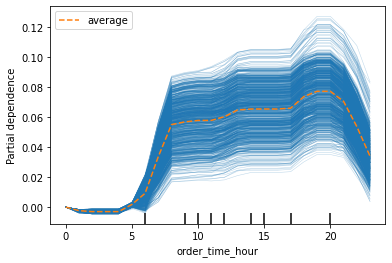

In [23]:
%%time
ICE = PartialDependenceDisplay.from_estimator(regressor, X[:1000], ['order_time_hour'], n_jobs = 6, kind='both', centered=True)
ICE.pd_results

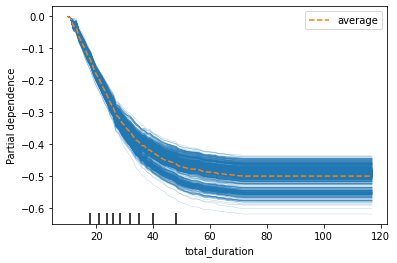

In [24]:
ICE = PartialDependenceDisplay.from_estimator(regressor, X[:1000], ['total_duration'], n_jobs = 6, kind='both', centered=True)

2767286
CPU times: user 3.72 s, sys: 5.91 s, total: 9.63 s
Wall time: 4min 16s


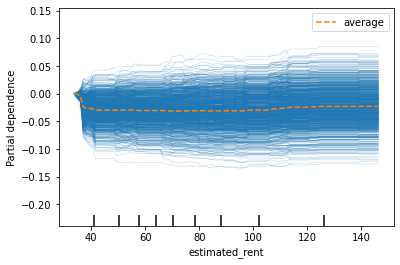

In [64]:
%%time
print(X.shape[0])
ICE_rent = PartialDependenceDisplay.from_estimator(regressor, X, ['estimated_rent'], n_jobs = 6, kind='both', centered=True)

In [65]:
df_localness['ICE_values'] = ICE_rent.pd_results[0].individual[0].tolist()
df_localness.to_csv('./output/food_localness_final_oct_withICE.csv',sep=',',index=False)

In [63]:
# print(np.shape(ICE_rent.pd_results[0].individual))
# ICE_rent.pd_results[0].individual[0]

# SHAP
"When using CatBoost, you do not need to manually encode categorical features. CatBoost natively handles categorical features, making it unnecessary to apply encoding techniques like one-hot encoding or label encoding. Simply specify the categorical features in the model training process."

In [15]:
# # Using numerical encoding for categorical features so that SHAP beeswarm can color coded high and low values of categorical features
# X_shap = X.copy()
# X_shap.loc[X_shap.rating == '1.Amazing', 'rating'] = 5
# X_shap.loc[X_shap.rating == '2.Very good', 'rating'] = 4
# X_shap.loc[X_shap.rating == '3.Good', 'rating'] = 3
# X_shap.loc[X_shap.rating == '4.OK', 'rating'] = 2
# X_shap.loc[X_shap.rating == '5.None', 'rating'] = 1

# X_shap.loc[X_shap.n_rating == '1.Amazing', 'n_rating'] = 5
# X_shap.loc[X_shap.n_rating == '2.Very good', 'n_rating'] = 4
# X_shap.loc[X_shap.n_rating == '3.Good', 'n_rating'] = 3
# X_shap.loc[X_shap.n_rating == '4.OK', 'n_rating'] = 2
# X_shap.loc[X_shap.n_rating == '5.None', 'n_rating'] = 1


# X_shap.loc[X_shap.isweekend == 'Yes', 'isweekend'] = 1
# X_shap.loc[X_shap.isweekend == 'No', 'isweekend'] = 0

# X_shap.loc[X_shap.incentive_delivery == 'Yes', 'incentive_delivery'] = 1
# X_shap.loc[X_shap.incentive_delivery == 'No', 'incentive_delivery'] = 0

# X_shap.loc[X_shap.incentive_menu_discount == 'Yes', 'incentive_menu_discount'] = 1
# X_shap.loc[X_shap.incentive_menu_discount == 'No', 'incentive_menu_discount'] = 0

# X_shap.loc[X_shap.incentive_voucher_wallet == 'Yes', 'incentive_voucher_wallet'] = 1
# X_shap.loc[X_shap.incentive_voucher_wallet == 'No', 'incentive_voucher_wallet'] = 0
# print(X_shap.shape[0]) #2767286

In [122]:
# %%time
# #  ~4min
# import shap
# print(datetime.datetime.now(),'*************** Start running SHAP ***************')
# explainer = shap.TreeExplainer(regressor)
# shap_values = explainer(X_shap)
# print(datetime.datetime.now(),'*************** Done running SHAP ***************')

In [120]:
# # apply Label Encoding over categorical features
# # https://stackoverflow.com/questions/57285499/how-to-tell-the-shap-tree-explainer-and-shap-values-calculator-which-variables-a
# X_shap = X.copy()
# X_shap['rating'] = X_shap['rating'].astype('category')
# X_shap['rating'] = X_shap['rating'].cat.codes

# X_shap['n_rating'] = X_shap['n_rating'].astype('category')
# X_shap['n_rating'] = X_shap['n_rating'].cat.codes

# X_shap['isweekend'] = X_shap['isweekend'].astype('category')
# X_shap['isweekend'] = X_shap['isweekend'].cat.codes

# X_shap['incentive_delivery'] = X_shap['incentive_delivery'].astype('category')
# X_shap['incentive_delivery'] = X_shap['incentive_delivery'].cat.codes

# X_shap['incentive_menu_discount'] = X_shap['incentive_menu_discount'].astype('category')
# X_shap['incentive_menu_discount'] = X_shap['incentive_menu_discount'].cat.codes

# X_shap['incentive_voucher_wallet'] = X_shap['incentive_voucher_wallet'].astype('category')
# X_shap['incentive_voucher_wallet'] = X_shap['incentive_voucher_wallet'].cat.codes

# # X_shap['main_cuisine'] = X_shap['main_cuisine'].astype('category')
# # X_shap['main_cuisine'] = X_shap['main_cuisine'].cat.codes

# X_shap = X.copy()
# X_shap = pd.get_dummies(X_shap)
# X_shap

In [32]:
%%time
#  ~4min
import shap
print(datetime.datetime.now(),'*************** Start running SHAP ***************')
explainer = shap.TreeExplainer(regressor)
shap_values = explainer(X)
print(datetime.datetime.now(),'*************** Done running SHAP ***************')

2024-09-12 21:30:02.238163 *************** Start running SHAP ***************
2024-09-12 21:37:32.766233 *************** Done running SHAP ***************
CPU times: user 2h 2min 45s, sys: 55 s, total: 2h 3min 40s
Wall time: 7min 38s


In [33]:
print(df_localness.order_id.unique().shape[0])
df_localness.head(2)

2782961


account_id    order_id  order_date           order_time  vendor_id       vendor_name main_cuisine vertical  delivery_fee_amount_lc  service_fee_amount_lc  basket_amount_lc is_incentive_applied  incentive_amount_lc       pickup_id  customer_lon  customer_lat  vendor_lon  vendor_lat  order_time_hour  delivery_duration  total_duration     node_id  nearest_dist1  poi1 n_vertical  n_vendor_id n_main_cuisine                                        n_vendor_name  n_vendor_lon  n_vendor_lat  vendor_index  pandana_distance_realdist  pandana_localness   speed     customer_loc_id isweekend  price_per_item  entropy_0.5km  restaurant_count_0.5km  entropy_1km  poi_count_1km  entropy_2km  poi_count_2km  entropy_3km  poi_count_3km  entropy_4km  poi_count_4km  entropy_5km  poi_count_5km  restaurant_count_0.5_1km  restaurant_count_1_2km  restaurant_count_2_3km  restaurant_count_3_4km  restaurant_count_4_5km  estimated_rent  compensation  discounted delivery  free delivery     gem  item discount  \
0  1237695     1304769890  2023-10-10  2023-10-10 00:54:08  701885     Subz, AlBarsha 3  american     food    7.50000                 1.92000                64.00000           True                30.00000             249052903.00000 55.14407      25.06988      55.19383    25.08783     0                21                 50              2669233716 0.68807         1778  food       660366       american       Cheat Day - Burgers & Salads, Jumeirah Lakes Towers 55.14022      25.06550       1778         7.29895                    0.09427            8.75754  55.14406625.069883  No       0.00000         0.70242        169.00000               0.73641      322.00000      0.74026      782.00000      0.73911      853.00000      0.73745      933.00000      0.73241      1138.00000     153.00000                 460.00000               71.00000                80.00000                205.00000               87.94369        0.00000       0.00000              0.00000        0.00000 0.00000          
1  1027548     1304769334  2023-10-10  2023-10-10 00:53:16  701885     Subz, AlBarsha 3  american     food    7.50000                 1.92000                64.00000           True                30.00000             249052903.00000 55.14435      25.06983      55.19383    25.08783     0                16                 46              2669233716 0.68807         1778  food       660366       american       Cheat Day - Burgers & Salads, Jumeirah Lakes Towers 55.14022      25.06550       1778         7.29895                    0.09427            9.51906  55.1443525.06983    No       0.00000         0.65899        121.00000               0.73415      318.00000      0.74026      782.00000      0.73911      853.00000      0.73800      933.00000      0.73241      1138.00000     197.00000                 464.00000               71.00000                80.00000                205.00000               88.00245        0.00000       0.00000              0.00000        0.00000 0.00000          

   menu discount  voucher wallet incentives_type  incentive_delivery  incentive_menu_discount  incentive_voucher_wallet  rating     n_rating  consistency  total_orders  
0 30.00000       0.00000          menu discount   False               True                     False                     5.None  2.Very good 0.87874       11            
1 30.00000       0.00000          menu discount   False               True                     False                     5.None  2.Very good 0.88989       23

### save SHAP values

In [34]:
%%time
# this takes 
shaplist = ['shap_'+i for i in X.columns]
df_shape_values = pd.DataFrame(shap_values.values, columns=shaplist)

df_shape_values['account_id'] = df_localness['account_id']
df_shape_values['customer_lon'] = df_localness['customer_lon']
df_shape_values['customer_lat'] = df_localness['customer_lat']

df_shape_values['vendor_id'] = df_localness['vendor_id']
df_shape_values['vendor_lon'] = df_localness['vendor_lon']
df_shape_values['vendor_lat'] = df_localness['vendor_lat']

df_shape_values['order_id'] = df_localness['order_id']
first_column = df_shape_values.pop('order_id')
df_shape_values.insert(0, 'order_id', first_column)

# df_shape_values
df_shape_values.to_csv('./output/food_localness_final_oct_new_shap_values.csv',sep=',',index=False)
df_shape_values.head()

CPU times: user 1min 31s, sys: 1.27 s, total: 1min 32s
Wall time: 1min 33s


order_id  shap_customer_lon  shap_customer_lat  shap_basket_amount_lc  shap_price_per_item  shap_order_time_hour  shap_total_duration  shap_estimated_rent  shap_entropy_0.5km  shap_entropy_2km  shap_entropy_5km  shap_incentive_amount_lc  shap_incentive_delivery  shap_incentive_menu_discount  shap_incentive_voucher_wallet  shap_main_cuisine  shap_isweekend  shap_consistency  shap_total_orders  shap_rating  shap_n_rating  shap_restaurant_count_0.5km  shap_restaurant_count_0.5_1km  shap_restaurant_count_1_2km  shap_restaurant_count_2_3km  shap_restaurant_count_3_4km  shap_restaurant_count_4_5km  account_id  customer_lon  customer_lat  vendor_id  vendor_lon  vendor_lat
0  1304769890 -0.00700           -0.01416           -0.01049               -0.03658             0.05246               -0.05788             -0.01585             0.00036             -0.00766          0.00060           0.01495                   -0.00232                 0.01096                       0.00100                        -0.02045           0.00069         0.00302           -0.00381           -0.00390     0.00393        -0.07875                     -0.01005                       0.01626                      -0.02434                     0.00044                      -0.00006                      1237695    55.14407      25.06988       701885    55.19383    25.08783   
1  1304769334 0.00155            -0.01932           -0.00655               -0.03077             0.05136               -0.03860             -0.01359             -0.01035            -0.00673          0.00457           0.01726                   -0.00001                 0.00937                       0.00102                        -0.00446           -0.00003        -0.00126          -0.00231           0.01493      0.00445        -0.06185                     -0.01068                       0.00895                      -0.01686                     0.00066                      -0.00035                      1027548    55.14435      25.06983       701885    55.19383    25.08783   
2  1306219965 -0.01347           -0.02119           0.00027                0.02538              0.03483               0.01954              -0.01046             -0.00508            -0.01530          -0.00191          -0.00811                  0.00005                  -0.01162                      -0.00086                       0.00638            -0.00073        -0.00293          -0.00914           0.00652      0.02472        -0.08642                     -0.00981                       -0.00867                     -0.00991                     -0.00350                     -0.00520                      6430278    55.14407      25.06991       699240    55.13087    25.07603   
3  1295994041 -0.01150           -0.02168           -0.00094               0.02542              0.03613               0.05872              -0.01017             -0.00242            -0.01868          -0.00022          -0.00852                  0.00004                  -0.00976                      -0.00056                       0.01619            -0.00055        -0.00360          -0.00835           0.01021      0.02568        -0.09305                     -0.01366                       -0.00944                     -0.00957                     -0.00265                     -0.00616                      6430278    55.14407      25.06991       699240    55.13087    25.07603   
4  1304742536 -0.00545           -0.02307           -0.00619               -0.01789             0.02276               -0.02453             -0.00766             -0.03050            -0.01598          0.00167           0.02036                   -0.00529                 0.00153                       0.00001                        -0.01623           0.00070         -0.00121          -0.00197           -0.04450     -0.02838       -0.06445                     -0.00714                       -0.01947                     -0.00973                     -0.00985                     -0.02598                      91644

### SHAP feature importance

2024-09-12 21:39:06.247447 *************** Start running SHAP importance ***************
2024-09-12 21:39:41.800936 *************** Done running SHAP importance ***************
CPU times: user 32.9 s, sys: 2.81 s, total: 35.7 s
Wall time: 35.6 s


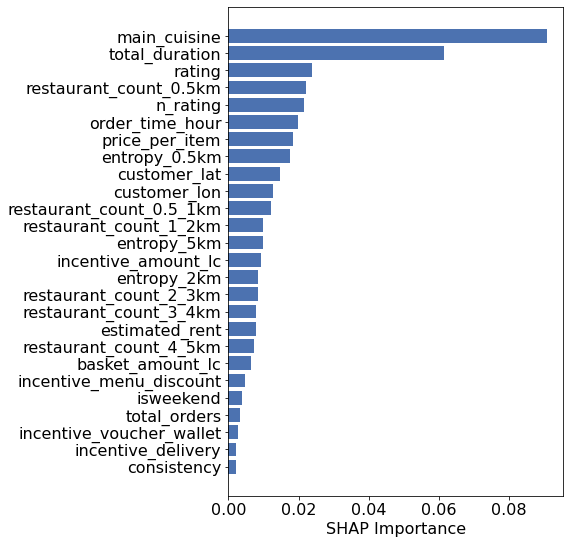

In [35]:
%%time
print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(6,9))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center',color="#4c72b0") #'turquoise'
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.xlabel('SHAP Importance')
plt.savefig('./output/feature_importance_shap.pdf', bbox_inches='tight')
print(datetime.datetime.now(),'*************** Done running SHAP importance ***************')

In [36]:
# Sum up SHAP importance by groups of features
df_shap = pd.DataFrame({
    'col': np.array(X.columns)[sorted_idx],
    'shap': shap_importance[sorted_idx]
})
df_shap.set_index('col', inplace=True)
df_shap = df_shap.T
print('order level', df_shap['basket_amount_lc'] + df_shap['price_per_item'] + df_shap['order_time_hour'] + df_shap['total_duration'] + df_shap['incentive_amount_lc'] + 
      df_shap['incentive_delivery'] + df_shap['incentive_voucher_wallet'] + df_shap['incentive_menu_discount'] + df_shap['isweekend'] 
      + df_shap['n_rating'] + df_shap['rating'] + df_shap['main_cuisine'])
print('user level', df_shap['consistency'] + df_shap['total_orders'] + df_shap['customer_lon'] + df_shap['customer_lat'])
print('neighborhood level', df_shap['estimated_rent'] + df_shap['restaurant_count_3_4km'] + df_shap['restaurant_count_4_5km'] + df_shap['restaurant_count_2_3km'] + 
      df_shap['restaurant_count_1_2km']+ df_shap['entropy_5km']+ df_shap['entropy_2km']+ df_shap['restaurant_count_0.5_1km']+ df_shap['entropy_0.5km'] + 
     df_shap['restaurant_count_0.5km'])

order level shap   0.26468
dtype: float64
user level shap   0.03266
dtype: float64
neighborhood level shap   0.11073
dtype: float64


In [43]:
# %%time
# # This is the visualization function offered by shap package for feature importance. ~1min
# print(datetime.datetime.now(),'*************** Start running SHAP importance ***************')
# #Plot the mean absolute value of the SHAP values
# fig_shapimportance = shap.plots.bar(shap_values, max_display=50,show=False)
# plt.savefig('./output/shap_importance.pdf', bbox_inches='tight')
# print(datetime.datetime.now(),'*************** Done running SHAP importance ***************')

2024-09-12 21:39:41.944574 *************** Start running beeswarm ***************
2024-09-12 21:50:13.334613 *************** Done running beeswarm ***************
CPU times: user 10min 20s, sys: 14.4 s, total: 10min 35s
Wall time: 10min 31s


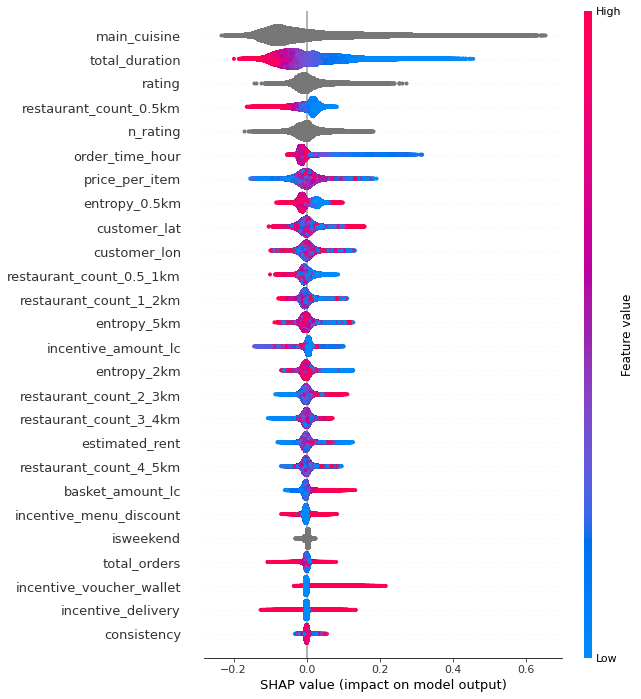

In [37]:
%%time
# ~6min
# Reading about gray colors: https://mlconference.ai/blog/tutorial-explainable-machine-learning-with-python-and-shap/
print(datetime.datetime.now(),'*************** Start running beeswarm ***************')
fig_beeswarm = shap.plots.beeswarm(shap_values,show=False, max_display=50)
plt.savefig('./output/shap_beeswarm_updated_longlat.pdf', bbox_inches='tight')
# plt.savefig('./output/shap_beeswarm_updated.pdf', bbox_inches='tight')
print(datetime.datetime.now(),'*************** Done running beeswarm ***************')

## Plot SHAP dependence plot between a pair of features

In [3]:
def plot_shap_interaction(var1, var2):
    fig = shap.dependence_plot(var1, shap_values.values, X, dot_size=5, alpha=0.4,
                           interaction_index=var2, show=False) #, ax=ax
    plt.savefig('./output/shap_' + var1 + '_' + var2 + '.pdf',bbox_inches='tight')

In [2]:
# var_interact1 = 'restaurant_count_0.5km'
var_interact2 = 'entropy_0.5km'
var_interact3 = 'estimated_rent'

feature_list_continuous_for_shap = ['basket_amount_lc','price_per_item','order_time_hour','total_duration',
  'consistency', 'total_orders', 'entropy_2km', 'entropy_5km', 'restaurant_count_0.5km',
  'restaurant_count_0.5_1km', 'restaurant_count_1_2km', 'restaurant_count_2_3km', 'restaurant_count_3_4km',
  'restaurant_count_4_5km']

2024-09-13 09:55:10.499068 basket_amount_lc entropy_0.5km Running!!!
2024-09-13 09:55:35.688713 basket_amount_lc entropy_0.5km Done!!!
2024-09-13 09:55:35.688814 price_per_item entropy_0.5km Running!!!
2024-09-13 09:56:01.736262 price_per_item entropy_0.5km Done!!!
2024-09-13 09:56:01.736684 order_time_hour entropy_0.5km Running!!!
2024-09-13 09:56:27.130682 order_time_hour entropy_0.5km Done!!!
2024-09-13 09:56:27.131003 total_duration entropy_0.5km Running!!!
2024-09-13 09:56:52.142321 total_duration entropy_0.5km Done!!!
2024-09-13 09:56:52.142418 consistency entropy_0.5km Running!!!
2024-09-13 09:57:17.238701 consistency entropy_0.5km Done!!!
2024-09-13 09:57:17.238801 total_orders entropy_0.5km Running!!!
2024-09-13 09:57:41.809023 total_orders entropy_0.5km Done!!!
2024-09-13 09:57:41.809122 entropy_2km entropy_0.5km Running!!!
2024-09-13 09:58:07.555121 entropy_2km entropy_0.5km Done!!!
2024-09-13 09:58:07.555226 entropy_5km entropy_0.5km Running!!!
2024-09-13 09:58:32.837099 en

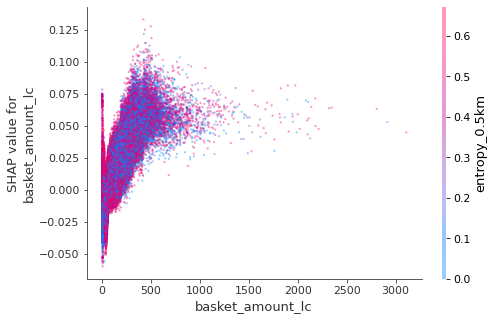

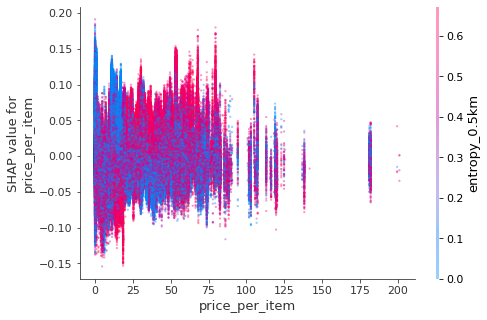

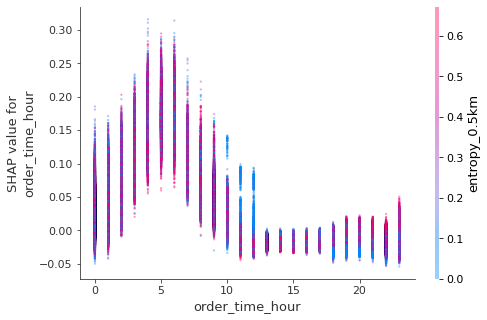

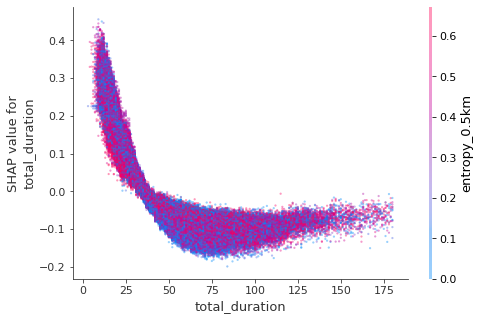

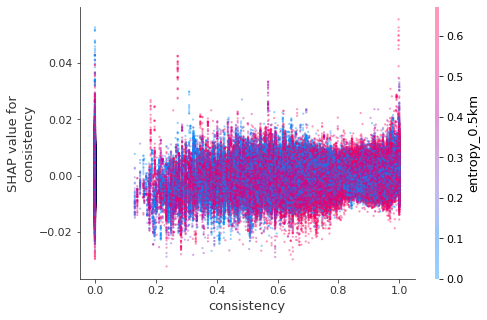

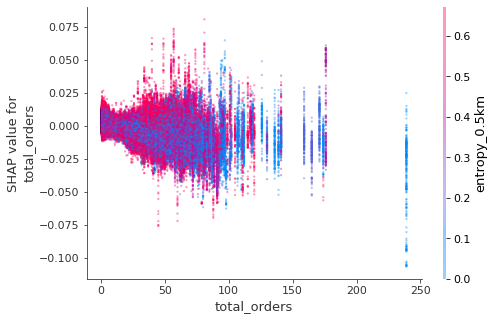

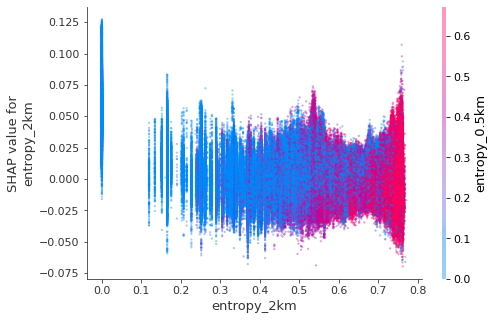

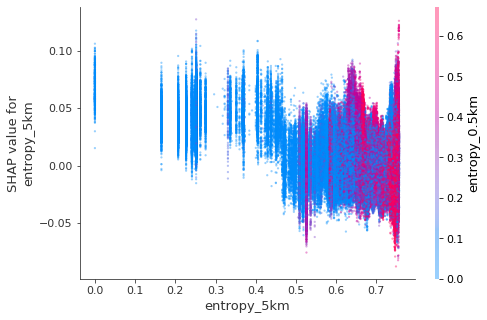

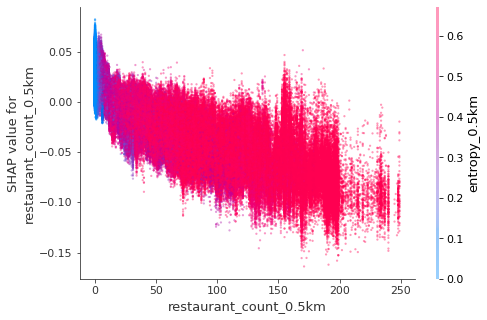

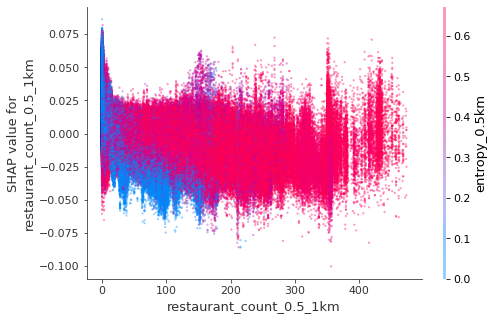

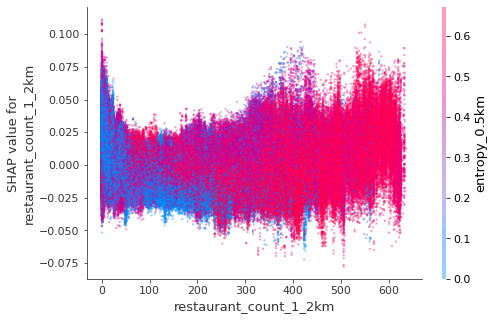

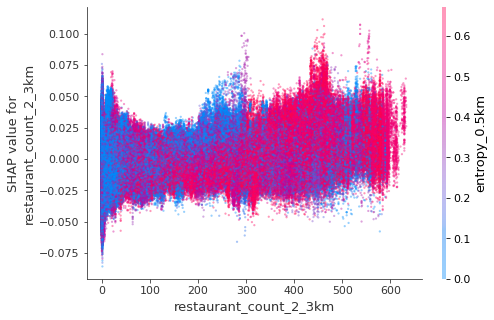

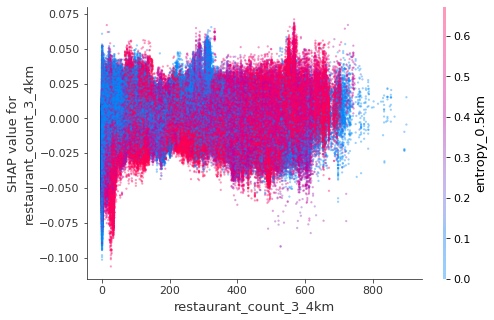

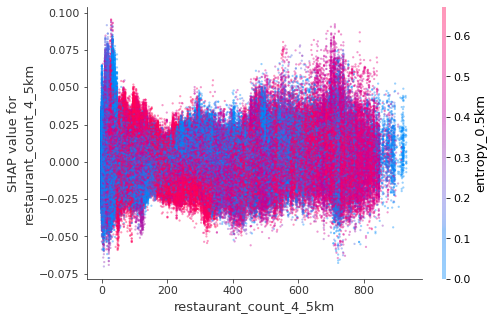

In [41]:
%%time
# ~12min interaction plot with var_interact2 = 'entropy_0.5km'
for var in feature_list_continuous_for_shap:
    print(datetime.datetime.now(), var, var_interact2,'Running!!!')
    plot_shap_interaction(var, var_interact2)
    print(datetime.datetime.now(), var, var_interact2,'Done!!!')

2024-09-13 10:02:44.118833 basket_amount_lc estimated_rent Running!!!
2024-09-13 10:03:14.734527 basket_amount_lc estimated_rent Done!!!
2024-09-13 10:03:14.735677 price_per_item estimated_rent Running!!!
2024-09-13 10:03:48.138437 price_per_item estimated_rent Done!!!
2024-09-13 10:03:48.138552 order_time_hour estimated_rent Running!!!
2024-09-13 10:04:12.434598 order_time_hour estimated_rent Done!!!
2024-09-13 10:04:12.434707 total_duration estimated_rent Running!!!
2024-09-13 10:04:36.792304 total_duration estimated_rent Done!!!
2024-09-13 10:04:36.792405 consistency estimated_rent Running!!!
2024-09-13 10:05:02.284458 consistency estimated_rent Done!!!
2024-09-13 10:05:02.284564 total_orders estimated_rent Running!!!
2024-09-13 10:05:27.026356 total_orders estimated_rent Done!!!
2024-09-13 10:05:27.026455 entropy_2km estimated_rent Running!!!
2024-09-13 10:05:52.701539 entropy_2km estimated_rent Done!!!
2024-09-13 10:05:52.701637 entropy_5km estimated_rent Running!!!
2024-09-13 10:

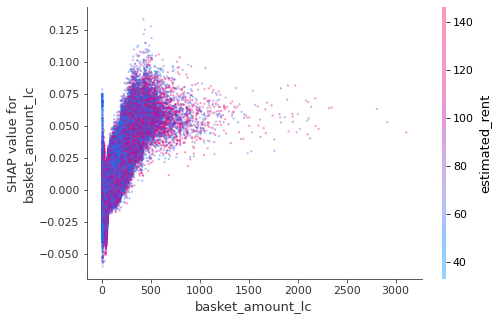

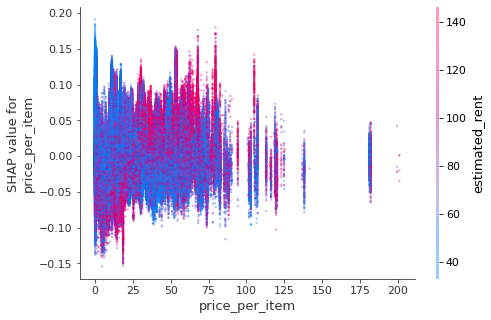

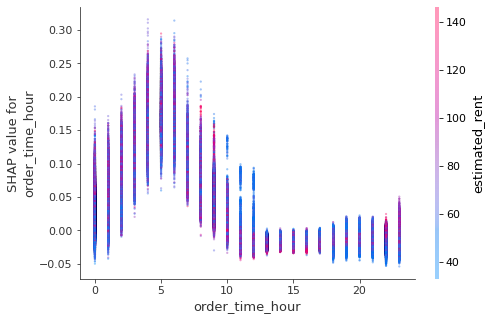

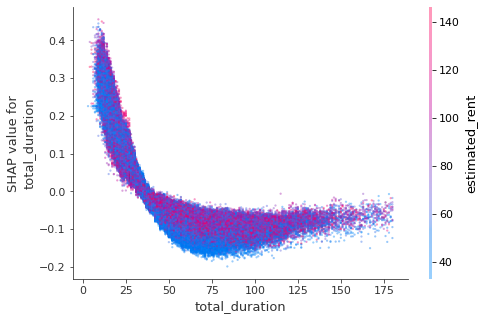

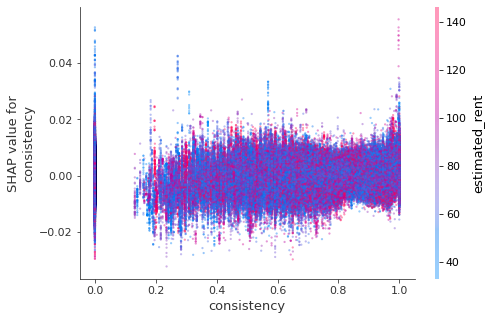

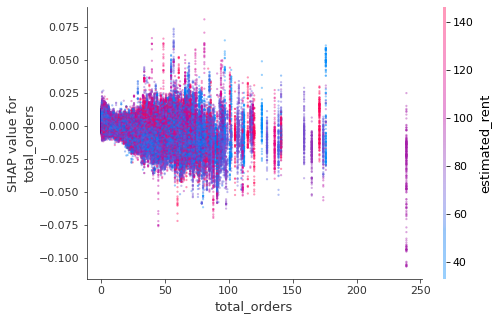

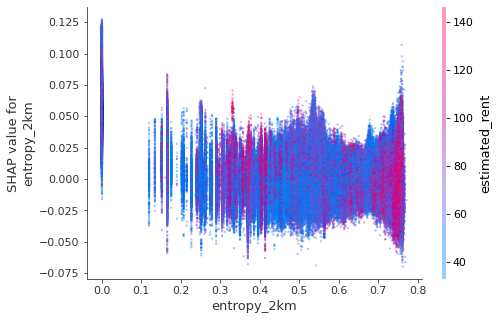

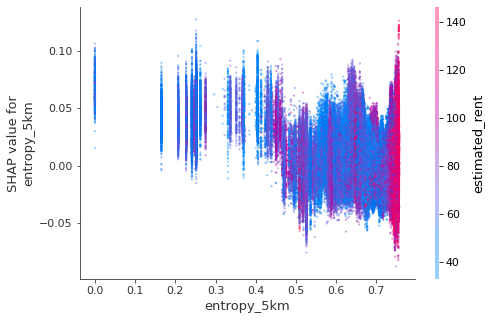

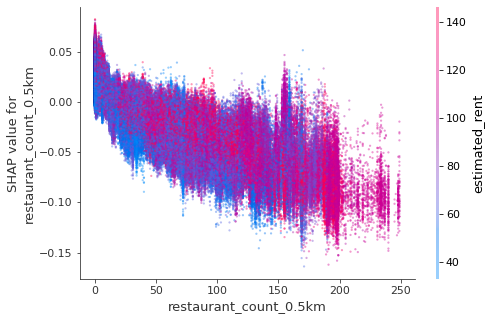

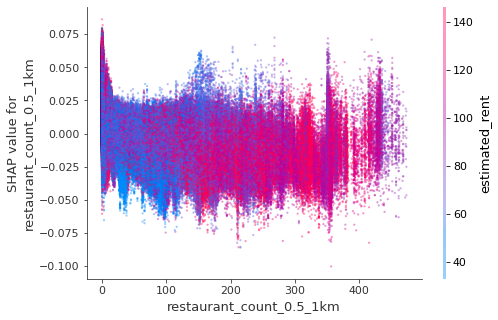

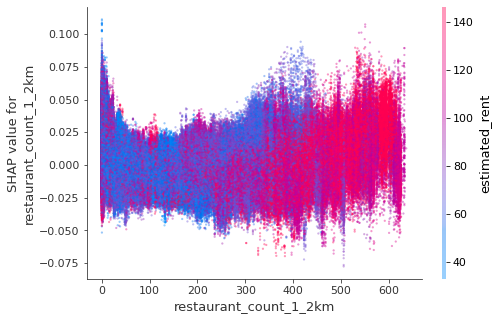

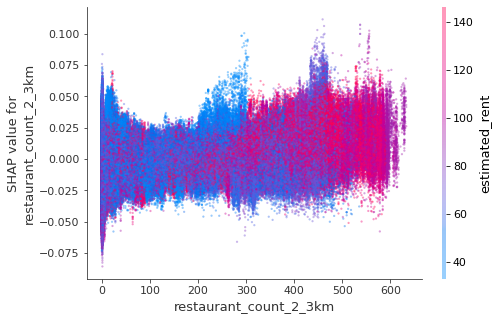

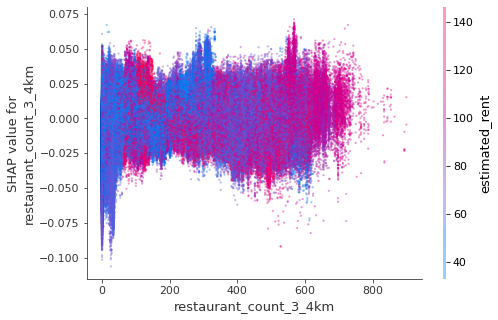

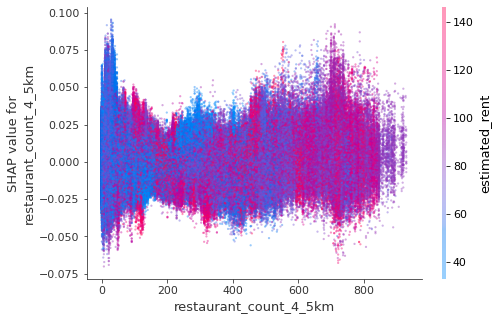

In [42]:
%%time
# ~12min interaction plot with var_interact3 = 'estimated_rent'
for var in feature_list_continuous_for_shap:
    print(datetime.datetime.now(), var, var_interact3,'Running!!!')
    plot_shap_interaction(var, var_interact3)
    print(datetime.datetime.now(), var, var_interact3,'Done!!!')

In [55]:
# %%time
# # ~12min interaction plot with var_interact1 = 'restaurant_count_0.5km'
# for var in feature_list_continuous_for_shap:
#     print(datetime.datetime.now(), var, var_interact1,'Running!!!')
#     plot_shap_interaction(var, var_interact1)
#     print(datetime.datetime.now(), var, var_interact1,'Done!!!')

CPU times: user 46.6 s, sys: 2.91 s, total: 49.5 s
Wall time: 49.1 s


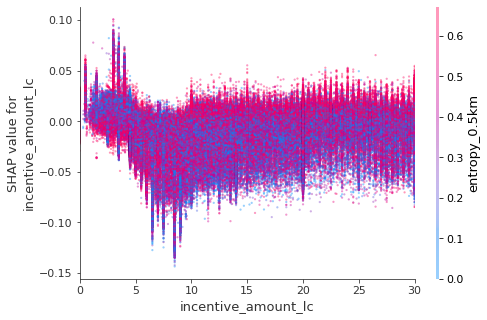

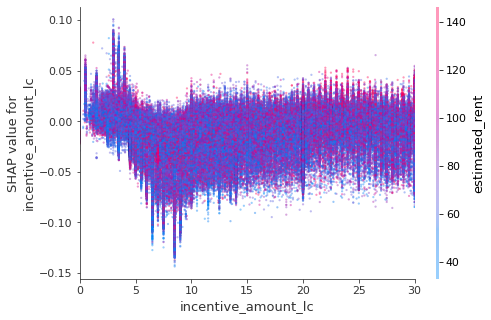

In [43]:
%%time

#for incentive we use this function because we need to modify the x axis range
def plot_shap_interaction_incentives(var1, x_jitter1=0):
    for var2 in [var_interact2, var_interact3]: #var_interact1
        fig_incentives = shap.dependence_plot(var1, shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index=var2, show=False, x_jitter=x_jitter1)
        plt.xlim(xmin=0,xmax=30)
        plt.savefig('./output/shap_' + var1 + '_' + var2 + '.pdf',bbox_inches='tight')    
        
# set a x limit for incentive plots if needed, cancel the comment line in function plot_shap_interaction_onevar()
plot_shap_interaction_incentives('incentive_amount_lc')

In [44]:
# this function is for those categorical features that we need to add a bit jitter to prevent overlapping points
def plot_shap_interaction_onevar(var1, x_jitter1=0):
    for var2 in [var_interact2, var_interact3]: #var_interact1
        fig_incentives = shap.dependence_plot(var1, shap_values.values, X, dot_size=5, alpha=0.4,
                               interaction_index=var2, show=False, x_jitter=x_jitter1)
        plt.savefig('./output/shap_' + var1 + '_' + var2 + '.pdf',bbox_inches='tight')

print(feature_list_cat)

['isweekend', 'incentive_delivery', 'incentive_menu_discount', 'incentive_voucher_wallet', 'rating', 'n_rating']


CPU times: user 4min 51s, sys: 20.6 s, total: 5min 11s
Wall time: 5min 9s


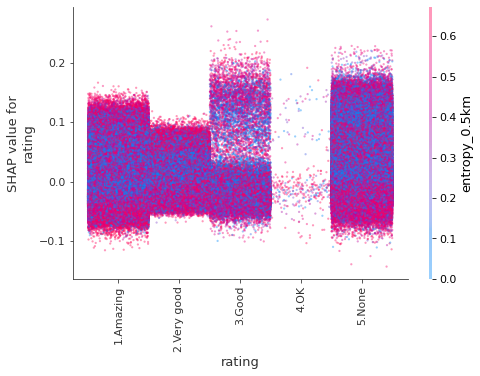

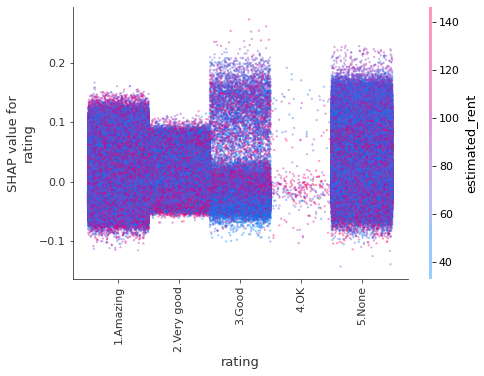

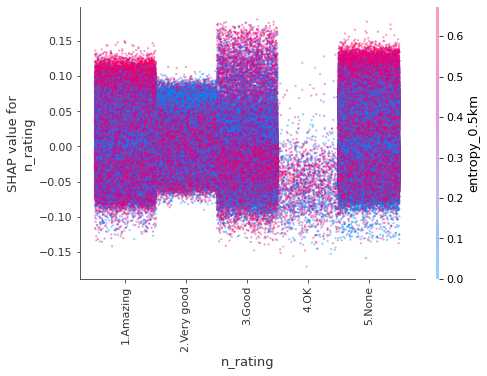

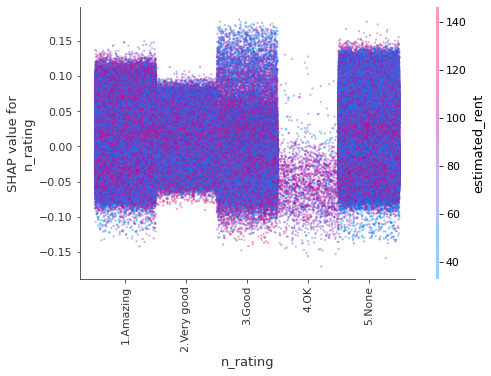

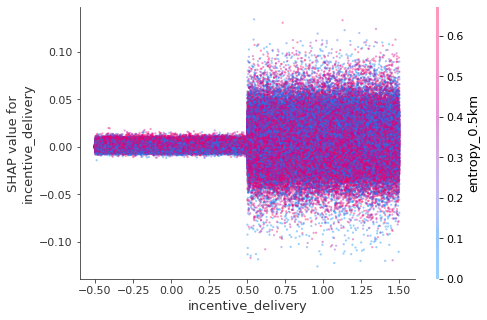

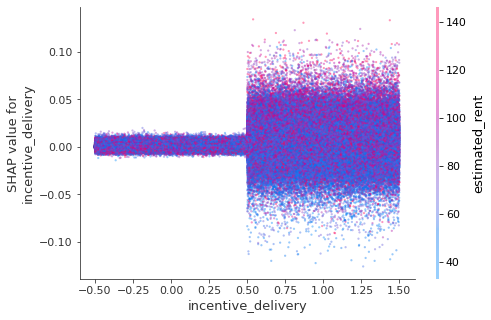

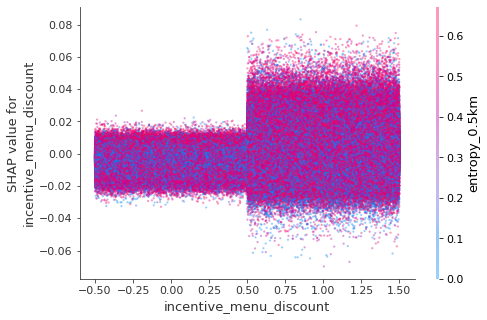

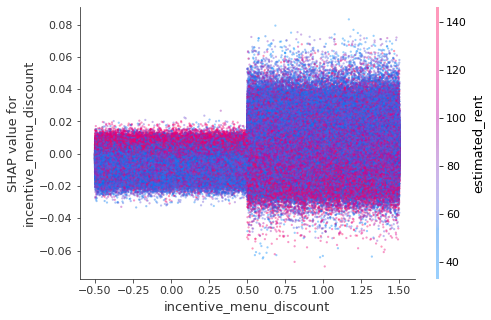

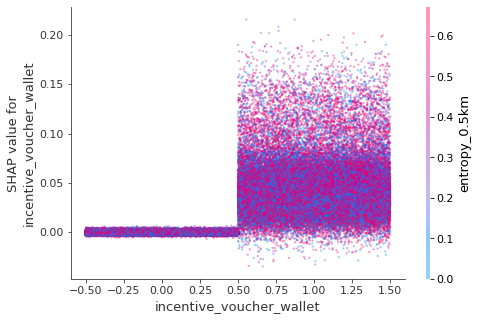

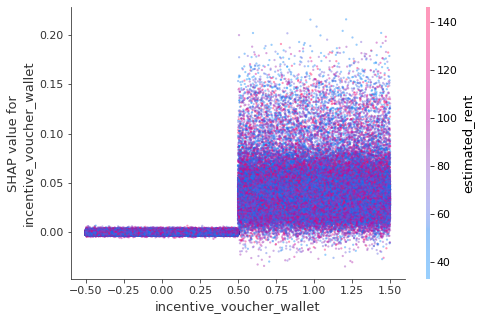

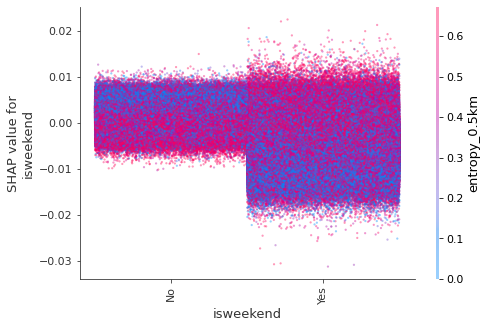

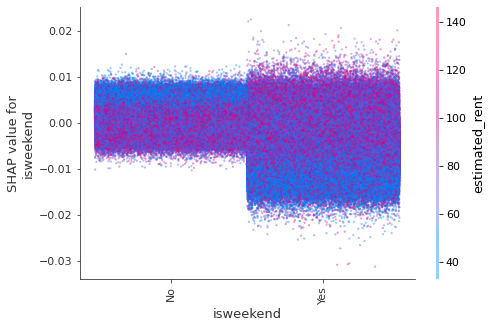

In [45]:
%%time
plot_shap_interaction_onevar('rating',x_jitter1=1)
plot_shap_interaction_onevar('n_rating',x_jitter1=1)
# plot_shap_interaction_onevar('order_time_hour',x_jitter1=1)
plot_shap_interaction_onevar('incentive_delivery',x_jitter1=1)
plot_shap_interaction_onevar('incentive_menu_discount',x_jitter1=1)
plot_shap_interaction_onevar('incentive_voucher_wallet',x_jitter1=1)
plot_shap_interaction_onevar('isweekend',x_jitter1=1)

# (Voided) SHAP interation plots 

SHAP dependence plot should be enough for interpretaion

In [ ]:
%%time
# may take a very long time
shap_interaction = explainer.shap_interaction_values(X)

## (Optional step) Focusing on most important interaction effects

In [ ]:
%%time
shap.dependence_plot(0, shap_values.values, X)
# interaction_index“auto”, pick the strongest interaction
# basket amount has a bigger effect on shorter duration orders than on longer duration orders

In [ ]:
%%time
shap.dependence_plot(1, shap_values.values, X)